In [ ]:
import os
import time
import math
import json
import torch
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, f1_score

%matplotlib inline

In [ ]:
torch.set_default_dtype(torch.float64) # melakukan set default floating precision ke 64

In [ ]:
def set_seed(seed):
    """
    Set seed untuk mendapatkan reproducible result

    Argumen:
    seed -- angka berapapun sebagai seed pada pembangkit bilangan acak
    """
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
path = "/content/drive/MyDrive/Semester 5/Pembelajaran Mesin/Tugas II/"

In [ ]:
dftrain = pd.read_csv(path+"encoded/training.csv")
dfvalid = pd.read_csv(path+"encoded/validation.csv")
dftest = pd.read_csv(path+"encoded/testing.csv")

In [ ]:
def convert_to_tensor(dfX):
    """
    Fungsi untuk mengonversi dataframe menjadi tensor
    """
    X = dfX.drop("Tertarik", axis=1)
    Y = dfX["Tertarik"]
    n_feature = X.shape[1]
    m_example = X.shape[0]
    datax = X.to_numpy()
    datay = Y.to_numpy()
    
    # jika terdeteksi GPU, maka tensor akan diadaptasi dengan "cuda"
    if torch.cuda.is_available():
        data_y = torch.from_numpy(datay.reshape(1, datay.shape[0]).astype(np.float64)).to(torch.device("cuda"))
        data_x = torch.from_numpy(datax.transpose().astype(np.float64)).to(torch.device("cuda"))
    else:
        data_y = torch.from_numpy(datay.reshape(1, datay.shape[0]).astype(np.float64))
        data_x = torch.from_numpy(datax.transpose().astype(np.float64))
    
    return data_x, data_y, n_feature, m_example

# Building Block of Neural Netwok

## Sigmoid

In [ ]:
def sigmoid(Z):
    """
    Implementasi fungsi aktivasi sigmoid di torch
    
    Argumen:
    Z -- torch tensor dengan ukuran berapapun
    
    Return:
    A -- keluaran dari sigmoid(z), ukurannya sama dengan Z
    cache -- mengembalikan nilai Z, berguna pada saat backward propagation 
    """

    A = 1/(1+torch.exp(-Z))
    cache = Z.detach().clone()
    
    return A, cache

In [ ]:
def sigmoid_backward(dA, cache):
    """
    Implementasi backward propagation untuk satu unit SIGMOID.

    Argumen:
    dA -- gradien yang sudah diaktivasi dengan ukuran berapapun
    cache -- 'Z' untuk menghitung backward propagation secara efisien

    Return:
    dZ -- Gradien dari cost berdasarkan nilai Z
    """

    Z = cache.detach().clone()
    
    s = 1/(1+torch.exp(-Z))
    dZ = torch.mul(dA, torch.mul(s, (1-s)))
    
    assert(tuple(dZ.size()) == tuple(Z.size()))
    
    return dZ

## ReLU

In [ ]:
def relu(Z):
    """
    Implementasi fungsi aktivasi ReLU

    Argumen:
    Z -- Nilai keluaran dari linear layer dengan ukuran berapapun

    Return:
    A -- Parameter yang sudah diaktivasi menggunakan ReLU, ukurannya sama dengan Z
    cache -- mengembalikan nilai Z, berguna pada saat backward propagation 
    """
    A = torch.max(torch.tensor(0.0), Z)
    
    assert(tuple(A.size()) == tuple(A.size()))
    
    cache = Z.detach().clone()
    return A, cache

In [ ]:
def relu_backward(dA, cache):
    """
    Implementasi backward propagation untuk satu unit ReLU

    Argumen:
    dA -- gradien yang sudah diaktivasi dengan ukuran berapapun
    cache -- 'Z' untuk menghitung backward propagation secara efisien

    Return:
    dZ -- Gradien dari cost berdasarkan nilai Z
    """

    Z = cache
    dZ = dA.detach().clone() # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert(tuple(dZ.size()) == tuple(Z.size()))
    
    return dZ

## Inisialisasi Parameter

In [ ]:
def initialize_parameters_deep(layer_dims, seed=42):
    """
    Argumen:
    layer_dims -- struktur data list pada python yang mengandung dimensi dari setiap layer pada neural network yang dibangun
    
    Return:
    parameters -- struktur data dictionary pada python yang mengandung parameter "W1", "b1", ..., "WL", "bL":
                    Wl -- matriks dari bobot dengan ukuran (layer_dims[l], layer_dims[l-1])
                    bl -- vektor dari nilai bias dengan ukuran (layer_dims[l], 1)
    """
    set_seed(seed)
    parameters = {}
    L = len(layer_dims) # jumlah layer pada neural network

    for l in range(1, L):
        if torch.cuda.is_available():
          parameters["W" + str(l)] = torch.randn(layer_dims[l], layer_dims[l-1], dtype=torch.float64, device=torch.device("cuda")) * 0.01
          parameters["b" + str(l)] = torch.zeros((layer_dims[l], 1), dtype=torch.float64, device=torch.device("cuda"))
        else:
          parameters["W" + str(l)] = torch.randn(layer_dims[l], layer_dims[l-1], dtype=torch.float64) * 0.01
          parameters["b" + str(l)] = torch.zeros((layer_dims[l], 1), dtype=torch.float64)

        assert(tuple(parameters['W' + str(l)].size()) == (layer_dims[l], layer_dims[l - 1]))
        assert(tuple(parameters['b' + str(l)].size()) == (layer_dims[l], 1))

        
    return parameters

## Forward Propagation

### Forward pada Unit Linear

In [ ]:
def linear_forward(A, W, b):
    """
    Implementasi fungsi linear pada forward propagation di satu layer

    Arguments:
    A -- akivasi dari layer sebelumnya (atau data masukan) dengan ukuran: (ukuran keluaran dari layer sebelumnya, banyaknya data)
    W -- berupa matriks yang berisi bobot: tensor dengan ukuran: (ukuran layer saat ini, ukuran layer sebelumnya)
    b -- vektor berisi bias, tensor dengan ukuran: (ukuran layer saat ini, 1)

    Returns:
    Z -- sebagai nilai masukan untuk fungsi aktivasi, atau bisa juga disebut parameter pre-activation 
    cache -- struktur data tuple pada python yang berisi "A", "W", dan "b" ; disimpan untuk melakukan penghitungan backward secara efisien
    """

    Z = torch.matmul(W, A)+b
    
    cache = (A.detach().clone(), W.detach().clone(), b.detach().clone())
    
    return Z, cache

### Forward pada Fungsi Aktivasi

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implementasi dari forward propagation untuk layer LINEAR->ACTIVATION

    Argument:
    A_prev -- aktivasi dari layer sebelumnya (atau berupa data masukan) dengan ukuran: (ukuran keluaran dari layer sebelumnya, banyaknya data)
    W -- berupa matriks yang berisi bobot: tensor dengan ukuran: (ukuran layer saat ini, ukuran layer sebelumnya)
    b -- vektor berisi bias, tensor dengan ukuran: (ukuran layer saat ini, 1)
    activation -- aktivasi yang akan digunakan pada layer ini, disimpan dalam sebuah string teks berupa: "sigmoid" atau "relu"

    Returns:
    A -- merupakan keluaran dari fungsi aktivasi. atau disebut juga nilai post-activation value 
    cache -- astruktur data tuple pada python yang berisi "linear_cache" adan "activation_cache";
             disimpan untuk melakukan penghitungan backward secara efisien
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

### Akumulasi Forward pada Model

In [ ]:
def L_model_forward(X, parameters):
    """
    Implementasi dari forward propagation untuk penghitungan [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID 

    Arguments:
    X -- data, berupa tensor dengan ukuran (ukuran data masukan, banyaknya data)
    parameters -- merupakan keluaran dari subprogram initialize_parameters_deep()
    
    Returns:
    AL -- nilai aktivasi dari keluaran pada layer terakhir
    caches -- struktur data list yang berisi:
                semua cache dari linear_activation_forward() (ada sebanyak L, diindeks dari 0 sampai L-1)
    """

    caches = []
    A = X.detach().clone()
    L = len(parameters) // 2                  # banyaknya layer pada neural network
    
    # Implementasi [LINEAR -> RELU]*(L-1). Menambahkan "cache" ke list dari "caches" 
    # Perulangan dimulai dari 1 karena layer 0 adalah input
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
          
    return AL, caches

### Penghitungan Cost

In [ ]:
def compute_cost(AL, Y):
    """
    Implementasi dari cost function, berupa rerata loss untuk semua data 

    Arguments:
    AL -- vektor yang berisi peluang berdasarkan label dari data yang diprediksi, ukurannya (1, banyaknya data)
    Y -- vektor yang berisi "label" data yang sebenarnya/label pada data training 
        (sebagai contoh: berisi 0 jika pelanggak tidak tertarik, 1 jika tertarik [pada kasus data pelanggan]), ukurannya (1, banyaknya data)

    Returns:
    cost -- cross-entropy cost
    """

    m = tuple(Y.size())[1]

    cost = (-1/m)*torch.sum(torch.multiply(Y, torch.log(AL))+torch.multiply(1-Y,torch.log(1-AL)), dtype=torch.float64)
    
    cost = torch.squeeze(cost).to(torch.float64)    # squeeze digunakan untuk memastikan ukuran dari hasil penghitungan cost merupkan sebuah angka tunggal, bukan tensor dengan dimensi banyak
                                                    # (misal, torch.squeeze([[37]]) akan menghasilkan 37).

    
    return cost

## Backward Propagation

### Backward pada Unit Linear

In [ ]:
def linear_backward(dZ, cache):
    """
    Implementasi dari backward propagation pada fungsi linear untuk satu

    Arguments:
    dZ -- Gradien dari dari cost berdasarkan keluaran dari fungsi linear (dari layer l saat ini)
    cache -- struktur data tuple yang berisi nilai dari (A_prev, W, b), berasal dari forward propagation di layer saat ini

    Returns:
    dA_prev -- Gradien dari cost terhadap aktivasi (dari layer sebelumnya l-1), ukurannya sama seperti A_prev
    dW -- Gradien dari cost terhadap  W (layer l saat ini), ukurannya sama seperti W
    db -- Gradien dari cost terhadap b (layer l saat ini), ukurannya sama seperti b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*torch.matmul(dZ, A_prev.t())
    db = (1/m)*torch.sum(dZ, axis=1, keepdims=True, dtype=torch.float64)
    dA_prev = torch.matmul(W.T, dZ)
    
    return dA_prev, dW, db

### Backward pada Fungsi Aktivasi

In [ ]:
def linear_activation_backward(dA, cache, activation):
    """
    Implementasi backward propagation untuk layer LINEAR->ACTIVATION.
    
    Arguments:
    dA -- post-activation gradient untuk layer l saat ini 
    cache -- struktur data tuple yang bernilai (linear_cache, activation_cache) 
    activation -- aktivasi yang digunakan pada layer ini, disimpan dalam sebuah sting teks: "sigmoid" atau "relu"
    
    Returns:
    dA_prev -- Gradien dari cost terhadap aktivasi (dari layer sebelumnya l-1), ukurannya sama seperti A_prev
    dW -- Gradien dari cost terhadap  W (layer l saat ini), ukurannya sama seperti W
    db -- Gradien dari cost terhadap b (layer l saat ini), ukurannya sama seperti b
    """
    linear_cache = cache[0]
    activation_cache = cache[1]
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

### Akumulasi Backward pada Model

In [ ]:
def L_model_backward(AL, Y, caches):
    """
    Implementasi dari akumulasi backward propagation pada model [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID
    
    Arguments:
    AL -- vektor yang berisi probabilitas, merupakan keluaran dari hasil forward propagation (L_model_forward())
    Y -- vektor yang berisi label pada data yang dipakai (berisi 0 jika pelanggan tidak tertarik, dan 1 jika tertarik)
    caches -- struktur data list yang berisi caches:
                setiap cache dari linear_activation_forward() dengan aktivasi "relu" (isinya caches[l], for l in range(L-1) i.e l = 0...L-2)
                cache dari linear_activation_forward() dengan aktivasi "sigmoid" (isinya caches[L-1])
    
    Returns:
    grads -- Struktur data dictionary dengan gradient
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = tuple(AL.size())[1]
    Y = Y.reshape(tuple(AL.size())) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (torch.divide(Y, AL) - torch.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    
    current_cache = caches[-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp.detach().clone()
    grads["dW" + str(L)] = dW_temp.detach().clone()
    grads["db" + str(L)] = db_temp.detach().clone()
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp.detach().clone()
        grads["dW" + str(l+1)] = dW_temp.detach().clone()
        grads["db" + str(l+1)] = db_temp.detach().clone()
  
    return grads

## Update Parameter

In [ ]:
def update_parameters(params, grads, learning_rate):
    """
    Memperbarui parameter menggunakan gradient descent
    
    Arguments:
    params -- struktur data dictionary yang berisi parameter 
    grads -- struktur data dictionary yang berisi gradient, merupakan keluaran dari L_model_backward
    
    Returns:
    parameters -- struktur data dictionary yang berisi parameter yang sudah diperbarui 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters[str("W" + str(l+1))] =  parameters[str("W" + str(l+1))] - (learning_rate*grads["dW" + str(l+1)])
        parameters[str("b" + str(l+1))] =  parameters[str("b" + str(l+1))] - (learning_rate*grads["db" + str(l+1)])

    return parameters

## Prediksi

In [ ]:
def predict(X, y, parameters):
    """
    Fungsi yang digunakan untuk memprediksi data berdasarkan model neural network yang sudah dibangun
    
    Arguments:
    X -- data yang akan diprediksi
    y -- label sebenarnya (jika ada)
    parameters -- parameter dari model yang sudah ditraining
    
    Returns:
    p -- hasil prediksi dari data X
    f1 -- macro average f-1 score
    cost -- cost dari data
    """
    
    m = tuple(X.size())[1]
    n = len(parameters) // 2 # banyaknya layer pada neural network
    p = torch.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    cost = compute_cost(probas, y)
    
    # mengonversi probas ke prediksi biner 0/1
    for i in range(0, tuple(probas.size())[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    f1 = f1_score(y.cpu().numpy()[0], p.cpu().numpy()[0], average='macro')

    return p, f1, cost

# Eksperimen I: Vanilla Neural Network

## Pemodelan

In [ ]:
def L_layer_model(X, Y, valid_x, valid_y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, 
                  print_cost=False, seed=42, patience=50, valid_criterion="valid_cost", early_stopping=False):

    set_seed(seed) # mengeset nilai seed supaya hasilnya reproducible
    costs = [] # merekam nilai cost pada data training
    
    record_val = {} # merekam nilai performansi pada data validasi
    record_val["f1"] = []
    record_val["cost"] = []
    
    # inisialisasi parameter.
    parameters = initialize_parameters_deep(layers_dims)
    best_params = parameters
    ep = 0
    stop = 0 # variabel untuk mengontrol early stopping
    
    # inisialisasi jika early stopping bernilai True
    if early_stopping:
        if valid_criterion == "valid_cost":
            _, _, best_val = predict(valid_x, valid_y, parameters)
        elif valid_criterion == "f1":
            _, best_f1, _ = predict(valid_x, valid_y, parameters)

    # Perulangan (gradient descent)
    for i in tqdm(range(1, num_iterations+1)):
        
        # jika performansi model memburuk selama patience iterasi, maka hentikan training
        if stop == patience:
            print(i)
            break
        
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Menghitung cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Memperbarui parameter.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        ep = ep + 1
        
        # Menyimpan parameter terbaik berdasarkan valid_criterion
        if early_stopping:
            if valid_criterion == "valid_cost":
                _, current_f1_val, current_val = predict(valid_x, valid_y, parameters)
                record_val["cost"].append(current_val)
                record_val["f1"].append(current_f1_val)
                if current_val >= best_val:
                    stop += 1
                else:
                    best_params = deepcopy(parameters)
                    best_val = current_val
                    stop = 0
            elif valid_criterion == "f1":
                _, current_f1_val, current_val = predict(valid_x, valid_y, parameters)
                record_val["f1"].append(current_f1_val)
                record_val["cost"].append(current_val)
                if current_f1_val <= best_f1:
                    stop += 1
                else:
                    best_params = deepcopy(parameters)
                    best_f1 = current_f1_val
                    stop = 0
                    
        
        # Mencetak cost setiap 100 iterasi
        if print_cost and i % 100 == 0:
            print("\nTraining cost after iteration {}: {}".format(i, torch.squeeze(cost)))
        #if i % 100 == 0 or i == num_iterations:
        costs.append(cost)
    
    print("\nTraining cost after iteration {} and stop training after {}: {}".format(ep, ep-stop,  torch.squeeze(cost)))
    
    # evaluasi performansi pada data validasi menggunakan parameter terbaik pada data training
    _, f1_val, current_val = predict(valid_x, valid_y, best_params)
    
    return best_params, costs, current_val, ep-stop, f1_val, record_val

In [ ]:
def unit_tuning(dftrain, dfvalid, n_units= [16, 32, 64, 128, 256, 512], n_epoch=100000,
                patience=50, valid_criterion="valid_cost", lr=0.0075, seed=42, print_cost = False, early_stopping = False):
    """
    Merupakan fungsi untuk melakukan hyperparameter tuning pada jumlah unit pada hidden layer yang ke-1,
    arsitektur yang dipakai adalah model dengan 2 layer
    """
    best_units = n_units[0] # inisialisasi unit dengan performansi terbaik
    best_params = {} # dictionary untuk menyimpan parameter terbaik
    best_cost = 9999 # inisialisasi cost terbaik
    all_costs = [] # list untuk menyimpan semua record cost
    record = {} # dictionary untuk menyimpan performansi pada setiap unit
    best_f1 = 0.0 # inisialisasi f1-score terbaik
    record_best = {} # dictionary untuk menyimpan data terbaik dan keseluruhan
    criterion_rec = [] # list untuk menyimpan record performansi pada data validasi
    all_params = {} # list untuk menyimpan semua parameter
    
    for i, unit in enumerate(n_units):
        train_x, train_y, n, m = convert_to_tensor(dftrain)
        layers_dims = [n, unit, 1]

        valid_x, valid_y, n, m = convert_to_tensor(dfvalid)

        set_seed(seed)
        parameters, costs, cost_val, stop, f1_val, record_val = L_layer_model(train_x, train_y, valid_x, valid_y, layers_dims, 
                                                learning_rate=lr, num_iterations = n_epoch, print_cost = print_cost,
                                                seed=seed, patience=patience, valid_criterion=valid_criterion, early_stopping= early_stopping)
        set_seed(seed)
        
        record[unit] = {}
        record[unit]["f1"] = f1_val 
        record[unit]["val_cost"] = cost_val.tolist()
        record[unit]["jumlah_epoch"] = stop
        
        if valid_criterion == "valid_cost":
            if cost_val < best_cost:
                best_units = unit
                best_params = parameters
                best_cost = cost_val
        elif valid_criterion == "f1":
            if f1_val > best_f1:
                best_f1 = f1_val
                best_units = unit
                best_params = parameters
        
        all_costs.append(costs)
        all_params[unit] = parameters    
        criterion_rec.append(record_val)

    record_best["all_costs"] = all_costs
    record_best["best_params"] = best_params
    record_best["best_unit"] = best_units
    record_best["all_unit"] = n_units
    record_best["all_val_rec"] = criterion_rec
    record_best["all_params"] = all_params

    return record, record_best

## Hyperparameter Tuning

In [ ]:
hstr, record_best = unit_tuning(dftrain, dfvalid, n_units= [2, 3, 4, 5], 
                                n_epoch=1000, lr=0.0007, seed=42, print_cost=False, 
                                valid_criterion="valid_cost", early_stopping=True, patience=100)

100%|██████████| 1000/1000 [18:11<00:00,  1.09s/it]



Training cost after iteration 1000 and stop training after 1000: 0.6085968606146541


100%|██████████| 1000/1000 [18:00<00:00,  1.08s/it]



Training cost after iteration 1000 and stop training after 1000: 0.6085928296063807


100%|██████████| 1000/1000 [17:50<00:00,  1.07s/it]



Training cost after iteration 1000 and stop training after 1000: 0.6085963662973097


100%|██████████| 1000/1000 [18:11<00:00,  1.09s/it]



Training cost after iteration 1000 and stop training after 1000: 0.6085963002443833


## Evaluasi Performansi

In [ ]:
def serialization(record_bes, step=1):
    """
    Fungsi untuk mengembalikan mengonversi data yang bertipe tensor ke tipe asal (float)
    """
    record_best = deepcopy(record_bes)
    for k, _ in record_best["best_params"].items():
        record_best["best_params"][k] = record_best["best_params"][k].tolist()
    
    cost_val = []
    f1_val = []
    train_eval = []
    
    for i,_ in enumerate(record_best["all_val_rec"]):
        record_best["all_val_rec"][i]["cost"] = [ x.tolist() for x in record_best["all_val_rec"][i]["cost"]]
        df = {"epoch": range(1, len(record_best["all_val_rec"][i]["cost"])+1, step), 
              "cost": [record_best["all_val_rec"][i]["cost"][x] for x in range(0, len(record_best["all_val_rec"][i]["cost"]), step)]}
        cost_val.append(df)
        
        record_best["all_val_rec"][i]["f1"] = [ x.tolist() for x in record_best["all_val_rec"][i]["f1"]]
        df = {"epoch": range(1, len(record_best["all_val_rec"][i]["f1"])+1, step), 
              "f1": [record_best["all_val_rec"][i]["f1"][x] for x in range(0, len(record_best["all_val_rec"][i]["f1"]), step)]}
        f1_val.append(df)
        
        record_best["all_costs"][i] = [ x.tolist() for x in record_best["all_costs"][i]]
        df = {"epoch": range(1, len(record_best["all_costs"][i])+1, step), 
              "performansi": [record_best["all_costs"][i][x] for x in range(0, len(record_best["all_costs"][i]), step)]}
        
        train_eval.append(record_best["all_costs"][i])
    
    
    
    return record_best, cost_val, f1_val, train_eval

In [ ]:
record_, cost_val, f1_val, train_eval = serialization(record_best)

In [ ]:
# menyimpan hasil evaluasi performansi ke dalam json
#with open("eval.json", "w") as outfile:
#    json.dump(hstr, outfile)

In [ ]:
# menyimpan record dari parameter terbaik ke json
#with open("record_best.json", "w") as outfile:
#    json.dump(record_, outfile)

In [ ]:
def evalplot(record, judul, xlab="epoch", ylab="cost", units=[1, 2, 3, 4]):
    f, axes = plt.subplots(2, 2, figsize=(20,7), gridspec_kw={'wspace': 0.4,'hspace': 0.4})
    f.suptitle(judul)
    
    for ax in axes.flat:
        ax.set(xlabel="epoch", ylabel=ylab)
    
    for i in range(len(units)):
        if i < 2:
            axes[0][i].plot(record[i][xlab], record[i][ylab])
            axes[0][i].set_title("Jumlah unit = " + str(units[i]))
            #plt.show()
        else:
            axes[1][i%2].plot(record[i][xlab], record[i][ylab])
            axes[1][i%2].set_title("Jumlah unit = " + str(units[i]))

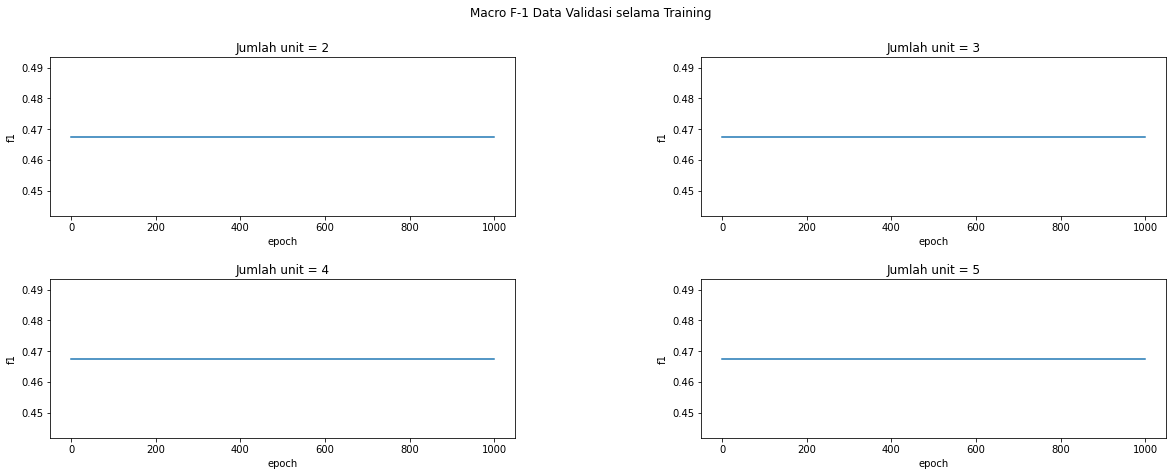

In [ ]:
evalplot(f1_val, "Macro F-1 Data Validasi selama Training", xlab="epoch", ylab="f1", units=[2, 3, 4, 5])

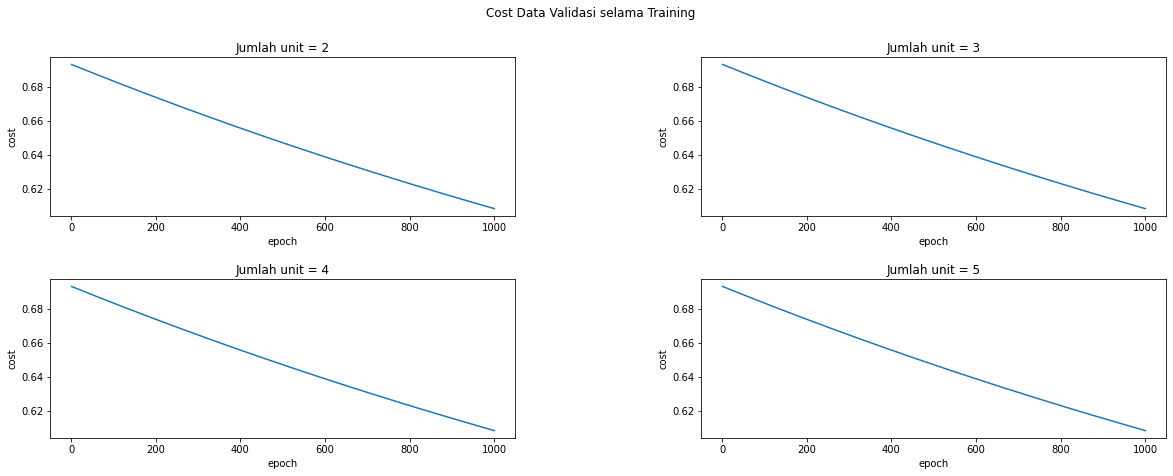

In [ ]:
evalplot(cost_val, "Cost Data Validasi selama Training", xlab="epoch", ylab="cost", units=[2, 3, 4, 5])

In [ ]:
train_x, train_y, n, m = convert_to_tensor(dftrain)
for i in [2, 3, 4, 5]:
    _, f1_train, cost_train = predict(train_x, train_y, record_best["all_params"][i])
    hstr[i]["f1_training"] = f1_train
    hstr[i]["cost_training"] = cost_train.tolist()

In [ ]:
# performansi pada data validasi
pd.DataFrame(hstr)

,2,3,4,5
f1,0.467636,0.467636,0.467636,0.467636
val_cost,0.608529,0.608525,0.608528,0.608528
jumlah_epoch,1000.000000,1000.000000,1000.000000,1000.000000
f1_training,0.467639,0.467639,0.467639,0.467639
cost_training,0.608526,0.608522,0.608526,0.608526


## Evaluasi pada Data Testing

In [ ]:
test_x, test_y, n, m = convert_to_tensor(dftest)

In [ ]:
_, f1_test, _ = predict(test_x, test_y, record_best["all_params"][2])
print("Macro Avg F-1 Score data test pada unit 2", f1_test)

Macro Avg F-1 Score data test pada unit 2 0.46722659002203165


In [ ]:
_, f1_test, _ = predict(test_x, test_y, record_best["all_params"][4])
print("Macro Avg F-1 Score data test pada unit 4", f1_test)

Macro Avg F-1 Score data test pada unit 4 0.46722659002203165


In [ ]:
#for k, _ in record_best["best_params"].items():
#    record_best["best_params"][k] = torch.tensor(record_best["best_params"][k], dtype=torch.float64)
_, f1_test, _ = predict(test_x, test_y, record_best["best_params"])
print("Macro Avg F-1 Score data test pada unit 3", f1_test)

Macro Avg F-1 Score data test pada unit 3 0.46722659002203165


In [ ]:
_, f1_test, _ = predict(test_x, test_y, record_best["all_params"][5])
print("Macro Avg F-1 Score data test pada unit 5", f1_test)

Macro Avg F-1 Score data test pada unit 5 0.46722659002203165


# Experiment II: Optimizing and Regularizing Neural Network

## He Initialization

In [ ]:
def initialize_parameters_deep_he(layer_dims, dev=None, seed=42):
    """
    Argumen:
    layer_dims -- struktur data list pada python yang mengandung dimensi dari setiap layer pada neural network yang dibangun
    
    Return:
    parameters -- struktur data dictionary pada python yang mengandung parameter "W1", "b1", ..., "WL", "bL":
                    Wl -- matriks dari bobot dengan ukuran (layer_dims[l], layer_dims[l-1])
                    bl -- vektor dari nilai bias dengan ukuran (layer_dims[l], 1)
    """
    if torch.cuda.is_available():
        dev = torch.device("cuda")

    set_seed(seed)
    parameters = {}
    L = len(layer_dims) # jumlah layer pada neural network

    for l in range(1, L):
        if torch.cuda.is_available():
          parameters["W" + str(l)] = torch.randn(layer_dims[l], layer_dims[l-1], dtype=torch.float64, device=torch.device("cuda"))*torch.sqrt(torch.Tensor([2.0/layer_dims[l-1]])).cuda()
          parameters["b" + str(l)] = torch.zeros((layer_dims[l], 1), dtype=torch.float64, device=torch.device("cuda"))
        else:
          parameters["W" + str(l)] = torch.randn(layer_dims[l], layer_dims[l-1], dtype=torch.float64)*torch.sqrt(torch.Tensor([2.0/layer_dims[l-1]], device=dev))
          parameters["b" + str(l)] = torch.zeros((layer_dims[l], 1), dtype=torch.float64)

        assert(tuple(parameters['W' + str(l)].size()) == (layer_dims[l], layer_dims[l - 1]))
        assert(tuple(parameters['b' + str(l)].size()) == (layer_dims[l], 1))

        
    return parameters

## Random Mini-batch

In [ ]:
def random_mini_batches(X_dat, Y_dat, mini_batch_size = 64, seed = 42):
  
    X = X_dat.detach().clone().cpu().numpy()
    Y = Y_dat.detach().clone().cpu().numpy()
    
    
    set_seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k*inc:(k+1)*inc]
        mini_batch_Y = shuffled_Y[:,k*inc:(k+1)*inc]

        if torch.cuda.is_available():
            mini_batch = (torch.from_numpy(mini_batch_X.astype(np.float64)).to(torch.device("cuda")), 
                          torch.from_numpy(mini_batch_Y.astype(np.float64)).to(torch.device("cuda")))
        else:
            mini_batch = (torch.from_numpy(mini_batch_X.astype(np.float64)), torch.from_numpy(mini_batch_Y.astype(np.float64)))
        
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches*inc:m]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches*inc:m]
        
        if torch.cuda.is_available():
            mini_batch = (torch.from_numpy(mini_batch_X.astype(np.float64)).to(torch.device("cuda")), 
                          torch.from_numpy(mini_batch_Y.astype(np.float64)).to(torch.device("cuda")))
        else:
            mini_batch = (torch.from_numpy(mini_batch_X.astype(np.float64)), torch.from_numpy(mini_batch_Y.astype(np.float64)))
        
        mini_batches.append(mini_batch)
    
    return mini_batches

## Adaptive Moment Estimation (ADAM)

In [ ]:
def initialize_adam(parameters, dev=None) :

    if torch.cuda.is_available():
        dev = torch.device("cuda")
        
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
        v["dW" + str(l)] = torch.zeros((tuple(parameters['W' + str(l)].size())[0], tuple(parameters['W' + str(l)].size())[1]), device=dev)
        v["db" + str(l)] = torch.zeros((tuple(parameters['b' + str(l)].size())[0], tuple(parameters['b' + str(l)].size())[1]), device=dev)
        s["dW" + str(l)] = torch.zeros((tuple(parameters['W' + str(l)].size())[0], tuple(parameters['W' + str(l)].size())[1]), device=dev)
        s["db" + str(l)] = torch.zeros((tuple(parameters['b' + str(l)].size())[0], tuple(parameters['b' + str(l)].size())[1]), device=dev)
    
    return v, s

In [ ]:
def update_parameters_with_adam(param, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    parameters = deepcopy(param)
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l)] = beta1*v["dW" + str(l)] + (1-beta1)*grads['dW' + str(l)]
        v["db" + str(l)] = beta1*v["db" + str(l)] + (1-beta1)*grads['db' + str(l)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l)] = v["dW" + str(l)]/(1-torch.pow(torch.tensor(beta1), t))
        v_corrected["db" + str(l)] = v["db" + str(l)]/(1-torch.pow(torch.tensor(beta1), t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l)] = beta2*s["dW" + str(l)] + (1-beta2)*torch.square(grads['dW' + str(l)])
        s["db" + str(l)] = beta2*s["db" + str(l)] + (1-beta2)*torch.square(grads['db' + str(l)])

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l)] = s["dW" + str(l)]/(1-torch.pow(torch.tensor(beta2), t))
        s_corrected["db" + str(l)] = s["db" + str(l)]/(1-torch.pow(torch.tensor(beta2), t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*(v_corrected["dW" + str(l)]/(torch.sqrt(s_corrected["dW" + str(l)])+torch.tensor(epsilon)))
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*(v_corrected["db" + str(l)]/(torch.sqrt(s_corrected["db" + str(l)])+torch.tensor(epsilon)))


    return parameters, v, s, v_corrected, s_corrected

In [ ]:
def model(X, Y, valid_x, valid_y, layers_dims, learning_rate = 0.0007, mini_batch_size=1024, num_epoch = 3000, 
          print_cost=False, patience=50, valid_criterion="f1", early_stopping=True, 
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, seed=42):

    set_seed(seed) # mengeset nilai seed supaya hasilnya reproducible
    costs = [] # merekam nilai cost pada data training
    
    record_val = {} # merekam nilai performansi pada data validasi
    record_val["f1"] = []
    record_val["cost"] = []
    
    # inisialisasi parameter.
    parameters = initialize_parameters_deep_he(layers_dims)
    v, s = initialize_adam(parameters)
    best_params = parameters
    ep = 0
    stop = 0 # variabel untuk mengontrol early stopping
    m = tuple(X.size())[1]
    t = 0
    
    # inisialisasi jika early stopping bernilai True
    if early_stopping:
        if valid_criterion == "valid_cost":
            _, _, best_val = predict(valid_x, valid_y, parameters)
        elif valid_criterion == "f1":
            _, best_f1, _ = predict(valid_x, valid_y, parameters)

    # Perulangan (gradient descent)
    for i in tqdm(range(1, num_epoch+1)):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        # jika performansi model memburuk selama patience iterasi, maka hentikan training
        if stop == patience:
            print(i)
            break
            
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = L_model_forward(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = L_model_backward(a3, minibatch_Y, caches)

            t = t + 1 # Adam counter
            parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m

        ep = ep + 1
        
        # Menyimpan parameter terbaik berdasarkan valid_criterion
        if early_stopping:
            if valid_criterion == "valid_cost":
                _, current_f1_val, current_val = predict(valid_x, valid_y, parameters)
                record_val["cost"].append(current_val)
                record_val["f1"].append(current_f1_val)
                if current_val >= best_val:
                    stop += 1
                else:
                    best_params = deepcopy(parameters)
                    best_val = current_val
                    stop = 0
            elif valid_criterion == "f1":
                _, current_f1_val, current_val = predict(valid_x, valid_y, parameters)
                record_val["f1"].append(current_f1_val)
                record_val["cost"].append(current_val)
                if current_f1_val <= best_f1:
                    stop += 1
                else:
                    best_params = deepcopy(parameters)
                    best_f1 = current_f1_val
                    stop = 0
                    
        
        # Mencetak cost setiap 100 iterasi
        if print_cost and i % 100 == 0:
            print("\nTraining cost after iteration {}: {}".format(i, torch.squeeze(cost_avg)))
        #if i % 100 == 0 or i == num_iterations:
        costs.append(cost_avg)
    
    print("\nTraining cost after iteration {} and stop training after {}: {}".format(ep, ep-stop,  torch.squeeze(cost_avg)))
    
    # evaluasi performansi pada data validasi menggunakan parameter terbaik pada data training
    _, f1_val, current_val = predict(valid_x, valid_y, best_params)
    
    return best_params, costs, current_val, ep-stop, f1_val, record_val

In [ ]:
def layer_tuning(dftrain, dfvalid, dftest, n_layer_dim=[[10, 16, 8, 1]],
                patience=5, valid_criterion="f1", lr=0.0007, 
                mini_batch_size=1024, num_epoch = 30, early_stopping=True, 
                beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8,
                seed=42, print_cost = False):
    """
    Merupakan fungsi untuk melakukan hyperparameter tuning pada dimensi layer tertentu
    """
    best_units = n_layer_dim[0] # inisialisasi unit dengan performansi terbaik
    best_params = {} # dictionary untuk menyimpan parameter terbaik
    best_cost = 9999 # inisialisasi cost terbaik
    all_costs = [] # list untuk menyimpan semua record cost
    record = {} # dictionary untuk menyimpan performansi pada setiap unit
    best_f1 = 0.0 # inisialisasi f1 terbaik
    hstr = {} # dictionary untuk menyimpan riwayat keseluruhan
    criterion_rec = [] # list untuk menyimpan record performansi pada data validasi
    all_params = {} # list untuk menyimpan semua parameter
    set_seed(seed)
    train_x, train_y, _, _ = convert_to_tensor(dftrain)
    valid_x, valid_y, _, _ = convert_to_tensor(dfvalid)
    test_x, test_y, _, _ = convert_to_tensor(dftest)
    
    
    for i, ld in enumerate(n_layer_dim):

        mulai = time.perf_counter()
        parameters, costs, cost_val, stop, f1_val, record_val = model(train_x, train_y, valid_x, valid_y, 
                                                                       ld, learning_rate = lr, 
                                                                       mini_batch_size=mini_batch_size, 
                                                                       num_epoch=num_epoch, print_cost=print_cost, 
                                                                       patience=patience, valid_criterion=valid_criterion, 
                                                                       early_stopping=early_stopping, beta1=beta1, beta2=beta2, 
                                                                       epsilon=epsilon, seed=seed)
        
        berhenti = time.perf_counter()
        durasi = (berhenti-mulai)/60

        _, f1_train, cost_train = predict(train_x, train_y, parameters)
        _, f1_test, cost_test = predict(test_x, test_y, parameters)

        record["experimen_"+str(i+1)] = {}
        record["experimen_"+str(i+1)]["arsitektur"] = '->'.join([str(ly) for ly in ld])
        record["experimen_"+str(i+1)]["f1_training"] = f1_train 
        record["experimen_"+str(i+1)]["f1_validasi"] = f1_val 
        record["experimen_"+str(i+1)]["f1_testing"] = f1_test
        record["experimen_"+str(i+1)]["cost_training"] = cost_train.tolist()
        record["experimen_"+str(i+1)]["cost_validasi"] = cost_val.tolist()
        record["experimen_"+str(i+1)]["cost_testing"] = cost_test.tolist()
        record["experimen_"+str(i+1)]["jumlah_epoch"] = stop
        record["experimen_"+str(i+1)]["durasi_training"] = str(f'{durasi:0.4f} menit')

        if valid_criterion == "valid_cost":
            if cost_val < best_cost:
                best_units = ld
                best_params = parameters
                best_cost = cost_val
        elif valid_criterion == "f1":
            if f1_val > best_f1:
                best_f1 = f1_val
                best_units = "experimen_"+str(i+1)
                best_params = parameters
        all_costs.append(costs)
        all_params["experimen_"+str(i+1)] = parameters    
        criterion_rec.append(record_val)

    hstr["hasil_eksperimen"] = deepcopy(record)
    hstr["all_costs"] = all_costs
    hstr["best_params"] = best_params
    hstr["best_unit"] = best_units
    hstr["all_dims"] = n_layer_dim
    hstr["all_val_rec"] = criterion_rec
    hstr["all_params"] = all_params

    return hstr

In [ ]:
def evplot(hstry, experimen=1):
    _, c_val, a_val, t_eval = serialization(hstry)
    name = 'experimen_'+str(experimen)+": "+hstry['hasil_eksperimen']['experimen_'+str(experimen)]['arsitektur']

    f, axes = plt.subplots(1, 3, figsize=(20,7), gridspec_kw={'wspace': 0.4,'hspace': 0.4})
    f.suptitle(name)
    
    ylab = ["cost", 'cost', 'f1']
    i=0

    for ax in axes.flat:
        ax.set(xlabel="epoch", ylabel=ylab[i])
        i+=1
    
    axes[0].plot([x for x in range(len(t_eval[int(experimen-1)]))], t_eval[int(experimen-1)])
    axes[0].set_title("Training Cost")

    axes[1].plot(c_val[0]["epoch"], c_val[0]["cost"])
    axes[1].set_title("Validation Cost")

    axes[2].plot(a_val[0]["epoch"], a_val[0]["f1"])
    axes[2].set_title("Validation f-1 score")


## Hyperparameter Tuning

In [ ]:
hist = layer_tuning(dftrain, dfvalid, dftest, n_layer_dim=[[10, 128, 64, 32, 3, 1], 
                                                   [10, 512, 256, 128, 64, 32, 3, 1], 
                                                   [10, 1024, 128, 512, 32, 3, 1], 
                                                   [10, 81, 27, 3, 1]],
                patience=100, valid_criterion="valid_cost", lr=0.0007, 
                mini_batch_size=2048, num_epoch = 1000, early_stopping=True, 
                beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8,
                seed=42, print_cost = False)

 31%|███       | 306/1000 [09:18<21:07,  1.83s/it]


307

Training cost after iteration 306 and stop training after 206: 9.642456452113329e-05


 20%|█▉        | 195/1000 [06:32<27:00,  2.01s/it]


196

Training cost after iteration 195 and stop training after 95: 0.00018264612702231892


 15%|█▍        | 147/1000 [04:47<27:47,  1.96s/it]


148

Training cost after iteration 147 and stop training after 47: 9.389461745635157e-05


 78%|███████▊  | 775/1000 [21:46<06:19,  1.69s/it]


776

Training cost after iteration 775 and stop training after 675: 9.65688950987689e-05


## Evaluasi Performansi

In [ ]:
pd.DataFrame(hist["hasil_eksperimen"])

,experimen_1,experimen_2,experimen_3,experimen_4
arsitektur,10->128->64->32->3->1,10->512->256->128->64->32->3->1,10->1024->128->512->32->3->1,10->81->27->3->1
f1_training,0.728602,0.467639,0.732274,0.732194
f1_validasi,0.732632,0.467636,0.735585,0.732492
f1_testing,0.557989,0.467227,0.561288,0.558642
cost_training,0.195913,0.370054,0.195724,0.195314
cost_validasi,0.19628,0.370076,0.196529,0.196889
cost_testing,1.00616,0.372928,0.909272,0.514715
jumlah_epoch,206,95,47,675
durasi_training,9.3524 menit,6.5812 menit,4.8276 menit,21.8119 menit


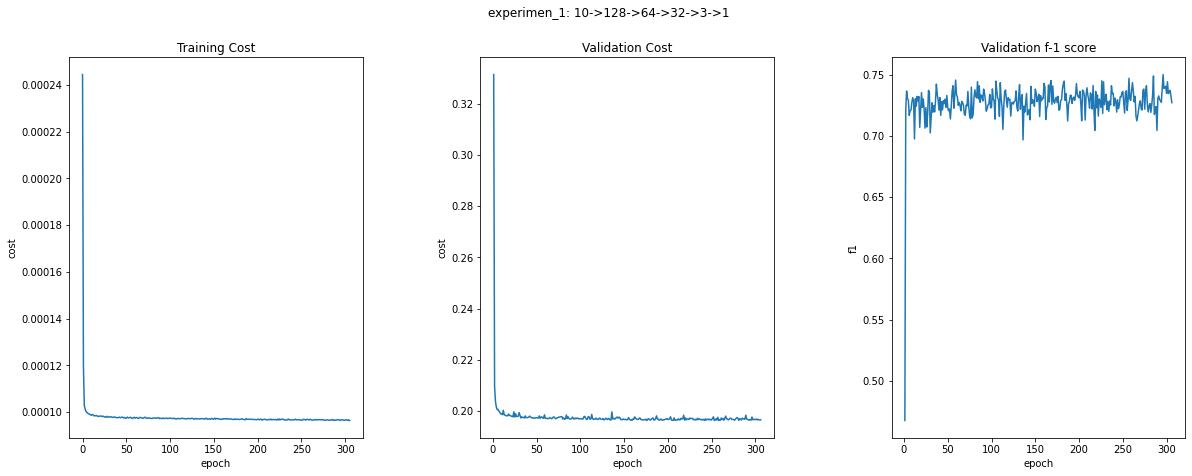

In [ ]:
evplot(hist, 1)

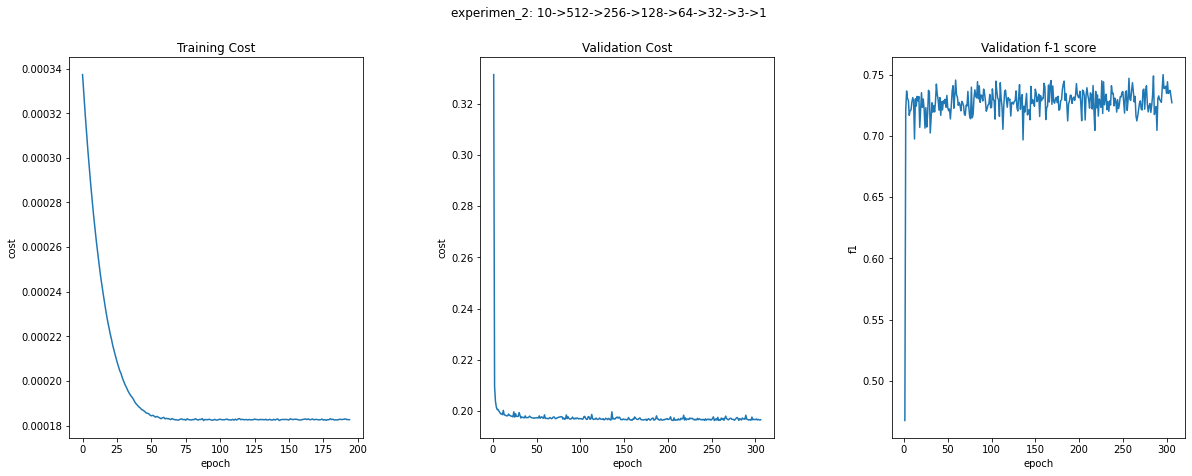

In [ ]:
evplot(hist, 2)

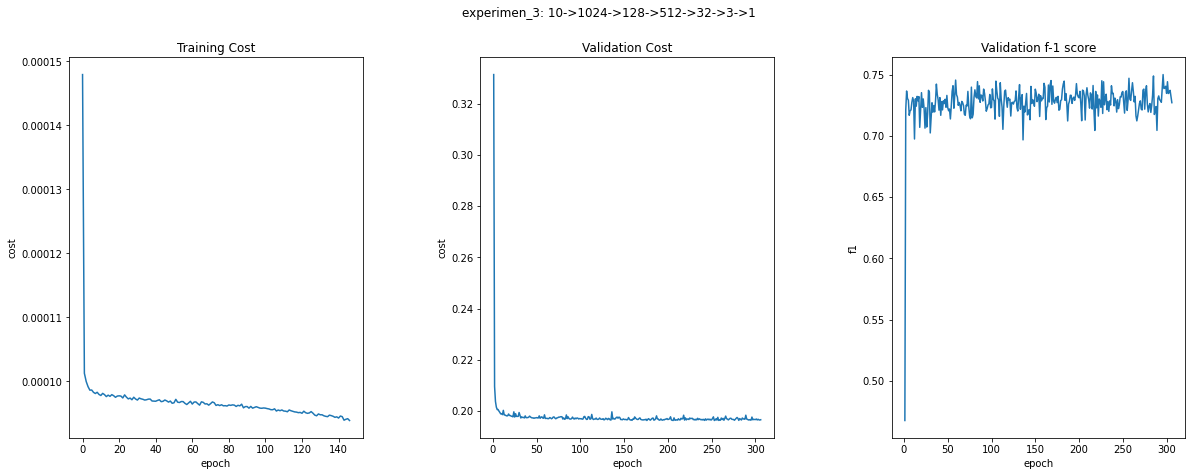

In [ ]:
evplot(hist, 3)

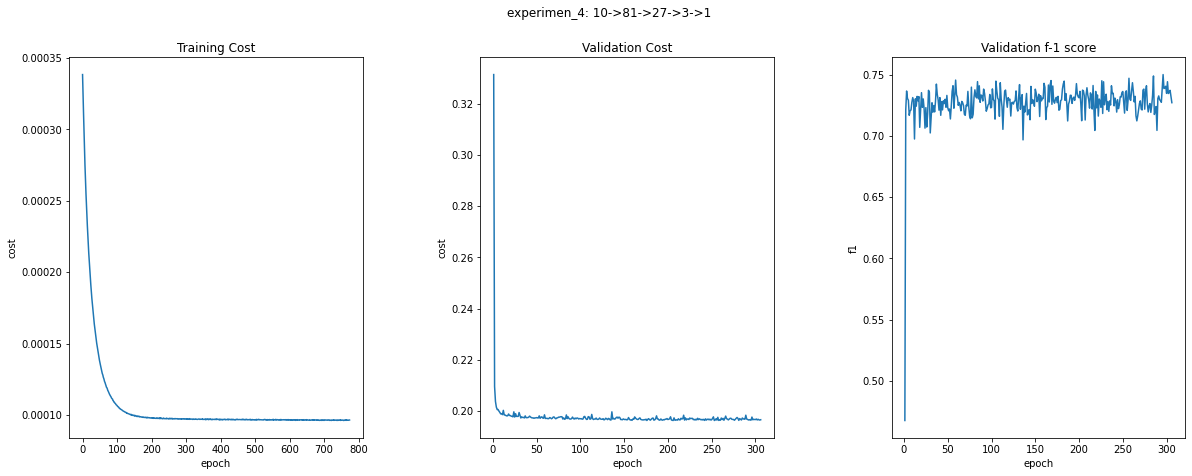

In [ ]:
evplot(hist, 4)